### Biblioteki

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import zstandard as zstd
import io

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import TensorDataset, DataLoader

from xgboost import XGBClassifier
from matplotlib import pyplot as plt

### Finałowy dataset

In [2]:
def create_dataframe_from_csv_zst(filepath: str) -> pd.DataFrame:
    dctx = zstd.ZstdDecompressor()
    with open(filepath, 'rb') as compressed:
        with dctx.stream_reader(compressed) as reader:
            decompressed = io.TextIOWrapper(reader, encoding='utf-8')
            df = pd.read_csv(
                decompressed,
                low_memory=True
            )
    return df

In [3]:
AMENITIES_PATH = "../data/processed/amenities_stats.csv.zst"
REVIEWS_STATISTICS_PATH = "../data/processed/merged_reviews_statistics.csv.zst"
LISTINGS_PATH = "../data/raw/v2/listings.csv.zst"
SESSIONS_STATISTICS_PATH = "../data/processed/listings_statistics.csv"

In [4]:
amenities_df = create_dataframe_from_csv_zst(AMENITIES_PATH)
reviews_statistics_df = create_dataframe_from_csv_zst(REVIEWS_STATISTICS_PATH)
listings_df = create_dataframe_from_csv_zst(LISTINGS_PATH)

/tmp/ipykernel_5149/3230345688.py:6: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [6]:
amenities_df.head(5)

,id,amenities,standardized_amenities,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities,mean_embedding
0,27262,"[""Heating - split type ductless system"", ""Dish...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'Refriger...",37,25,True,False,9,[-6.15361333e-02 -5.01407236e-02 -3.76954190e-...
1,809874,"[""Host greets you"", ""Dishes and silverware"", ""...","['OTHER', 'OTHER', 'Washer', 'TV', 'OTHER', 'R...",21,12,True,True,7,[-5.95615655e-02 -3.39257978e-02 -3.55266146e-...
2,866381,"[""Coffee"", ""Dishes and silverware"", ""Washer"", ...","['Coffee maker', 'OTHER', 'Washer', 'Condition...",49,29,True,True,12,[-5.62126637e-02 -3.99859361e-02 -3.53127755e-...
3,886724,"[""Host greets you"", ""Luggage dropoff allowed"",...","['OTHER', 'OTHER', 'Washer', 'OTHER', 'OTHER',...",20,13,True,True,6,[-5.84196560e-02 -4.62852195e-02 -3.04865874e-...
4,896212,"[""Host greets you"", ""Coffee"", ""Dishes and silv...","['OTHER', 'Coffee maker', 'OTHER', 'OTHER', 'O...",45,31,True,True,9,[-5.81393391e-02 -4.77810428e-02 -4.26256545e-...


In [7]:
reviews_statistics_df.head(5)

,listing_id,total_reviews,total_english_reviews,count_negative_english,count_positive_english
0,21853,33,17.0,1.0,16.0
1,27262,29,17.0,0.0,17.0
2,30320,172,133.0,15.0,118.0
3,30959,8,4.0,0.0,4.0
4,33945,78,60.0,2.0,58.0


In [8]:
listings_df.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,27262,https://www.nocarz.pl/rooms/27262,20241225065837,2024-12-25,city scrape,"AQA-No7, Great mattress, high speed internet",THE MATTRESS - KING KOIL - Camden Luxury 160x2...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,37177,...,t,1,1,0,0,0.19,NaN,NaN,NaN,NaN
1,809874,https://www.nocarz.pl/rooms/809874,20241225065837,2024-12-25,city scrape,Wonderfull Penthouse!!,NaN,NaN,https://a0.muscache.com/pictures/11813063/7d06...,4259738,...,f,1,1,0,0,0.68,NaN,NaN,NaN,NaN
2,866381,https://www.nocarz.pl/rooms/866381,20241225065837,2024-12-25,city scrape,Acropolis View Funky House,Welcome to a colorful 7th-floor penthouse in N...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,4551671,...,f,1,1,0,0,0.28,NaN,NaN,NaN,NaN
3,886724,https://www.nocarz.pl/rooms/886724,20241225065837,2024-12-25,city scrape,Luxury Boutique Appartment -Athens,NaN,The apartment is very conveniently located for...,https://a0.muscache.com/pictures/14659524/b33a...,4700824,...,f,1,1,0,0,0.14,NaN,NaN,NaN,NaN
4,896212,https://www.nocarz.pl/rooms/896212,20241225065837,2024-12-25,city scrape,Living like in a cottage in the center of Athens,An oasis of calm in the centre of a crowded ci...,Exarchia is considered the bohemian and altern...,https://a0.muscache.com/pictures/prohost-api/H...,4777984,...,t,13,13,0,0,3.58,NaN,NaN,NaN,NaN


In [9]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [5]:
interesting_columns = [
    'id',
    'host_is_superhost',
    'host_verifications',
    'host_acceptance_rate',
    'neighbourhood_cleansed',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'bathrooms',
    'bathrooms_text',
    'bedrooms',
    'beds',
    'price',
    'license',
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'instant_bookable',
    'reviews_per_month',
    'availability_eoy',
    'number_of_reviews_ly'
]

In [6]:
final_df = listings_df[interesting_columns].copy()
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,availability_eoy,number_of_reviews_ly
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,4.89,4.90,4.86,4.97,4.75,4.71,t,0.19,NaN,NaN
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,4.97,4.97,4.89,4.92,4.86,4.91,f,0.68,NaN,NaN
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,4.98,4.98,4.93,4.93,4.73,4.90,f,0.28,NaN,NaN
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,4.88,4.47,4.88,4.89,4.28,4.72,f,0.14,NaN,NaN
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,4.94,4.96,4.97,4.93,4.82,4.93,t,3.58,NaN,NaN


In [7]:
listings_statistics = pd.read_csv(SESSIONS_STATISTICS_PATH)
listings_statistics.head(5)

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,num_of_short_stays,num_of_long_stays
0,21853.0,33,48,1.454545,1,4,33,0
1,27262.0,29,144,4.965517,2,7,29,0
2,30320.0,172,360,2.093023,1,4,172,0
3,30959.0,8,12,1.500000,1,3,8,0
4,33945.0,78,540,6.923077,3,10,54,24


In [8]:
listings_statistics['target'] = np.where(
    listings_statistics['num_of_short_stays'] > listings_statistics['num_of_long_stays'],
    'short',
    'long'
)

In [10]:
listings_statistics.head()

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,num_of_short_stays,num_of_long_stays,target
0,21853.0,33,48,1.454545,1,4,33,0,short
1,27262.0,29,144,4.965517,2,7,29,0,short
2,30320.0,172,360,2.093023,1,4,172,0,short
3,30959.0,8,12,1.500000,1,3,8,0,short
4,33945.0,78,540,6.923077,3,10,54,24,short


In [9]:
listing_statistics_final_df = listings_statistics[['listing_id','total_bookings', 'target']].copy()

In [10]:
listing_statistics_final_df.head(5)

,listing_id,total_bookings,target
0,21853.0,33,short
1,27262.0,29,short
2,30320.0,172,short
3,30959.0,8,short
4,33945.0,78,short


### Złączenie datasetów

In [11]:
final_df = final_df.merge(
    listing_statistics_final_df,
    left_on='id',
    right_on='listing_id',
    how='left'
)
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,availability_eoy,number_of_reviews_ly,listing_id,total_bookings,target
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,4.97,4.75,4.71,t,0.19,NaN,NaN,27262.0,29.0,short
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,4.92,4.86,4.91,f,0.68,NaN,NaN,809874.0,97.0,short
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,4.93,4.73,4.90,f,0.28,NaN,NaN,866381.0,40.0,long
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,4.89,4.28,4.72,f,0.14,NaN,NaN,886724.0,18.0,short
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,4.93,4.82,4.93,t,3.58,NaN,NaN,896212.0,515.0,long


In [12]:
final_df= final_df.merge(
    reviews_statistics_df,
    left_on='id',
    right_on='listing_id',
    how='left'
)
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,availability_eoy,number_of_reviews_ly,listing_id_x,total_bookings,target,listing_id_y,total_reviews,total_english_reviews,count_negative_english,count_positive_english
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,NaN,NaN,27262.0,29.0,short,27262.0,29.0,17.0,0.0,17.0
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,NaN,NaN,809874.0,97.0,short,809874.0,97.0,82.0,0.0,82.0
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,NaN,NaN,866381.0,40.0,long,866381.0,40.0,31.0,0.0,31.0
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,NaN,NaN,886724.0,18.0,short,886724.0,18.0,17.0,1.0,16.0
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,NaN,NaN,896212.0,515.0,long,896212.0,515.0,423.0,3.0,420.0


In [13]:
final_df = final_df.merge(
    amenities_df,
    left_on='id',
    right_on='id',
    how='left'
)
final_df.head(5)

,id,host_is_superhost,host_verifications,host_acceptance_rate,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,count_negative_english,count_positive_english,amenities,standardized_amenities,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities,mean_embedding
0,27262,t,"['email', 'phone']",100%,ΑΜΠΕΛΟΚΗΠΟΙ,37.98924,23.76500,Entire rental unit,Entire home/apt,2,...,0.0,17.0,"[""Heating - split type ductless system"", ""Dish...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'Refriger...",37,25,True,False,9,[-6.15361333e-02 -5.01407236e-02 -3.76954190e-...
1,809874,f,"['email', 'phone']",96%,ΚΟΥΚΑΚΙ-ΜΑΚΡΥΓΙΑΝΝΗ,37.96215,23.72179,Entire rental unit,Entire home/apt,4,...,0.0,82.0,"[""Host greets you"", ""Dishes and silverware"", ""...","['OTHER', 'OTHER', 'Washer', 'TV', 'OTHER', 'R...",21,12,True,True,7,[-5.95615655e-02 -3.39257978e-02 -3.55266146e-...
2,866381,t,"['email', 'phone', 'work_email']",97%,ΝΕΟΣ ΚΟΣΜΟΣ,37.95523,23.72443,Entire condo,Entire home/apt,3,...,0.0,31.0,"[""Coffee"", ""Dishes and silverware"", ""Washer"", ...","['Coffee maker', 'OTHER', 'Washer', 'Condition...",49,29,True,True,12,[-5.62126637e-02 -3.99859361e-02 -3.53127755e-...
3,886724,f,['email'],0%,ΚΥΨΕΛΗ,37.99745,23.73973,Entire rental unit,Entire home/apt,2,...,1.0,16.0,"[""Host greets you"", ""Luggage dropoff allowed"",...","['OTHER', 'OTHER', 'Washer', 'OTHER', 'OTHER',...",20,13,True,True,6,[-5.84196560e-02 -4.62852195e-02 -3.04865874e-...
4,896212,t,"['email', 'phone']",100%,ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ,37.98844,23.73845,Entire rental unit,Entire home/apt,2,...,3.0,420.0,"[""Host greets you"", ""Coffee"", ""Dishes and silv...","['OTHER', 'Coffee maker', 'OTHER', 'OTHER', 'O...",45,31,True,True,9,[-5.81393391e-02 -4.77810428e-02 -4.26256545e-...


In [14]:
# how to drop target column with NaN?
final_df = final_df.dropna(subset=['target'])

In [15]:
# changing price to a numerical value
final_df['price'] = final_df['price'].replace('[\$,]', '', regex=True).astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_5149/3359693710.py:2: SyntaxWarning: invalid escape sequence '\$'
  final_df['price'] = final_df['price'].replace('[\$,]', '', regex=True).astype(float)


In [16]:
# droppin unnecesery columns
final_df.drop(columns=['listing_id_x', 'listing_id_y'], inplace=True)

In [17]:
# changing host_avaialbility_rate to a number
final_df['host_acceptance_rate'] = final_df['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\%'
<>:2: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_5149/1091464494.py:2: SyntaxWarning: invalid escape sequence '\%'
  final_df['host_acceptance_rate'] = final_df['host_acceptance_rate'].replace('[\%,]', '', regex=True).astype(float)


### Statystyki ostatecznego datasetu

In [18]:
final_df_numerical_columns = final_df.select_dtypes(include=[np.number, np.bool]).columns.tolist()
final_df_categorical_columns = final_df.select_dtypes(exclude=[np.number, np.bool]).columns.tolist()

print("Numerical columns: ", final_df_numerical_columns)
print("Categorical columns: ", final_df_categorical_columns)

Numerical columns:  ['id', 'host_acceptance_rate', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'availability_eoy', 'number_of_reviews_ly', 'total_bookings', 'total_reviews', 'total_english_reviews', 'count_negative_english', 'count_positive_english', 'num_of_amenities', 'num_of_other_amenities', 'has_wifi', 'has_air_conditioning', 'num_of_top_10_common_amenities']
Categorical columns:  ['host_is_superhost', 'host_verifications', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'license', 'instant_bookable', 'target', 'amenities', 'standardized_amenities', 'mean_embedding']


# Klasyfikatory

### Model Naiwny - Klasyfikator

In [24]:
# We assume that 0 will represent tha class that is more representative in the dataset
class NaiveClassifier(nn.Module):
    def __init__(self, input_size: int, output: int = 0):
        super(NaiveClassifier, self).__init__()
        self.input_size = input_size
        self.output = output


    def forward(self, x):
        batch_size = x.shape[0]
        logits = torch.zeros((batch_size, 2), dtype=torch.float32)
        logits[:, self.output] = 1.0
        return logits

### Model docelowy - Klasyfikator

In [25]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size: int, output_size: int):
        super(BinaryClassifier, self).__init__()
        self.input_size = input_size
        self.output_size = output_size

        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

        self.actv = F.relu

    def forward(self, x):
        x = self.actv(self.fc1(x))
        x = self.actv(self.fc2(x))
        x = self.fc3(x)

        return x


In [26]:
class BinaryClassifierEmbeddings(nn.Module):
    def __init__(self, num_numeric: int, embedding_sizes: list, output_size: int):
        super(BinaryClassifierEmbeddings, self).__init__()

        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim)
            for num_categories, emb_dim in embedding_sizes
        ])

        emb_dim_total = sum(emb_dim for _, emb_dim in embedding_sizes)
        self.input_size = num_numeric + emb_dim_total

        self.fc1 = nn.Linear(self.input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

        self.actv = F.relu

    def forward(self, x_cat, x_num):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embedded + [x_num], dim=1)

        x = self.actv(self.fc1(x))
        x = self.actv(self.fc2(x))
        x = self.fc3(x)
        return x

### Porównanie

In [32]:
def train_test_split_data(df: pd.DataFrame, test_size: float = 0.2, target_column: str = 'target'):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X = X.astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)

    # convert targets to int
    y_train = y_train.map({'short': 0, 'long': 1})
    y_test = y_test.map({'short': 0, 'long': 1})

    return X_train, X_test, y_train, y_test


def create_dataloader(x: pd.DataFrame, y: pd.Series, batch_size: int = 32):
    X_tensor = torch.tensor(x.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.long)

    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader


In [28]:
def train_classifier(
    model: nn.Module,
    train_loader: DataLoader,
    criterion,
    optimizer,
    num_epochs: int = 10,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # Wrap train_loader with tqdm for progress display
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    print("Training complete!")


def evaluate_model(model: nn.Module, test_loader: DataLoader, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    # Use tqdm for the evaluation progress
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
        all_preds.append(probs)
        all_labels.append(labels)

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accuracy = accuracy_score(all_labels, np.argmax(all_preds, axis=1))
    roc_auc = roc_auc_score(all_labels, all_preds[:, 1])
    avg_precision = average_precision_score(all_labels, all_preds[:, 1])
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")

    return all_preds, all_labels

#### Wersja 1

In [23]:
numerical_df = final_df[final_df_numerical_columns + ['target']].copy()
numerical_df = numerical_df.fillna(0)
numerical_df = numerical_df.drop(columns=['id'])
numerical_df.head(5)


,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,review_scores_accuracy,...,total_reviews,total_english_reviews,count_negative_english,count_positive_english,num_of_amenities_y,num_of_other_amenities_y,has_wifi_y,has_air_conditioning_y,num_of_top_10_common_amenities_y,target
0,100.0,37.98924,23.76500,2,1.0,1.0,1.0,131.0,4.86,4.89,...,29,17.0,0.0,17.0,37,25,True,False,9,short
1,96.0,37.96215,23.72179,4,1.0,1.0,2.0,108.0,4.96,4.97,...,97,82.0,0.0,82.0,21,12,True,True,7,short
2,97.0,37.95523,23.72443,3,1.0,1.0,1.0,85.0,4.95,4.98,...,40,31.0,0.0,31.0,49,29,True,True,12,long
3,0.0,37.99745,23.73973,2,1.0,1.0,1.0,56.0,4.61,4.88,...,18,17.0,1.0,16.0,20,13,True,True,6,short
4,100.0,37.98844,23.73845,2,1.0,1.0,1.0,63.0,4.95,4.94,...,515,423.0,3.0,420.0,45,31,True,True,9,long


In [30]:
numerical_df.shape

(28807, 24)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [32]:
x_train, x_test, y_train, y_test = train_test_split_data(
    numerical_df,
    test_size=0.2,
    target_column='target'
)

train_dataloader = create_dataloader(x_train, y_train, batch_size=32)
test_dataloader = create_dataloader(x_test, y_test, batch_size=32)

In [24]:
naive_classifier = NaiveClassifier(input_size=len(x_train.columns), output=0).to(device)

classifier_v1 = BinaryClassifier(input_size=len(x_train.columns), output_size=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_v1.parameters(), lr=0.001)

NameError: name 'NaiveClassifier' is not defined

In [34]:
all_preds, all_labels = evaluate_model(naive_classifier, test_dataloader)

Evaluating:   0%|          | 0/181 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 181/181 [00:00<00:00, 516.78it/s]


Accuracy: 0.7805
ROC AUC: 0.5000
Average Precision: 0.2195


In [ ]:
train_classifier(
    classifier_v1,
    train_dataloader,
    criterion,
    optimizer,
    num_epochs=50
)
all_preds, all_labels = evaluate_model(classifier_v1, test_dataloader)

### Wersja 2

In [19]:
final_df_ohe = final_df.copy()

In [20]:
final_df_ohe.drop(
    columns=['id', 'mean_embedding', 'listing_id_x', 'listing_id_y', 'amenities', 'standardized_amenities', 'neighbourhood_cleansed', 'license'],
    inplace=True,
    errors='ignore'
)
final_df_ohe.head()

,host_is_superhost,host_verifications,host_acceptance_rate,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,...,target,total_reviews,total_english_reviews,count_negative_english,count_positive_english,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities
0,t,"['email', 'phone']",100.0,37.98924,23.76500,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,29.0,17.0,0.0,17.0,37,25,True,False,9
1,f,"['email', 'phone']",96.0,37.96215,23.72179,Entire rental unit,Entire home/apt,4,1.0,1 bath,...,short,97.0,82.0,0.0,82.0,21,12,True,True,7
2,t,"['email', 'phone', 'work_email']",97.0,37.95523,23.72443,Entire condo,Entire home/apt,3,1.0,1 bath,...,long,40.0,31.0,0.0,31.0,49,29,True,True,12
3,f,['email'],0.0,37.99745,23.73973,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,18.0,17.0,1.0,16.0,20,13,True,True,6
4,t,"['email', 'phone']",100.0,37.98844,23.73845,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,long,515.0,423.0,3.0,420.0,45,31,True,True,9


In [21]:
neighbourhood_cleansed_values = final_df_ohe['neighbourhood_cleansed'].unique()
print(len(neighbourhood_cleansed_values))

KeyError: 'neighbourhood_cleansed'

In [23]:
non_numerical_columns = final_df_ohe.select_dtypes(include=['object', 'category']).columns
non_numerical_columns = non_numerical_columns.drop('target')
print(non_numerical_columns)

Index(['host_is_superhost', 'host_verifications', 'property_type', 'room_type',
       'bathrooms_text', 'instant_bookable'],
      dtype='object')


In [24]:
# one_hot_encoding
ohe_df = pd.get_dummies(final_df_ohe, columns=non_numerical_columns)

In [25]:
ohe_df.drop(columns=['availability_eoy', 'number_of_reviews_ly'], inplace=True)

In [26]:
ohe_df = ohe_df.fillna(0)

In [45]:
x_train, x_test, y_train, y_test = train_test_split_data(
    ohe_df,
    test_size=0.2,
    target_column='target'
)

train_dataloader = create_dataloader(x_train, y_train, batch_size=32)
test_dataloader = create_dataloader(x_test, y_test, batch_size=32)

In [46]:
classifier_v2 = BinaryClassifier(input_size=len(x_train.columns), output_size=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier_v2.parameters(), lr=0.001)

In [47]:
assert not x_train.isnull().any().any(), "NaNs found in x_train"
assert not np.isinf(x_train.to_numpy()).any(), "Infs found in x_train"
assert set(y_train.unique()).issubset({0, 1}), "Invalid labels in y_train"

In [ ]:
train_classifier(
    classifier_v2,
    train_dataloader,
    criterion,
    optimizer,
    50,
    device
)

In [49]:
all_preds, all_labels = evaluate_model(classifier_v2, test_dataloader, device)

Evaluating: 100%|██████████| 181/181 [00:00<00:00, 799.52it/s]

Accuracy: 0.9401
ROC AUC: 0.9824
Average Precision: 0.9479


In [ ]:
torch.save(classifier_v2.state_dict(), "../models/OHE_CLASSIFIER.pth")

#### Wersja 3

In [62]:
embeddings = final_df.copy()

In [52]:
embeddings = embeddings.drop(columns=['availability_eoy','number_of_reviews_ly', 'id'])
embeddings = embeddings.fillna(0)

In [53]:
emb_categorical_columns = embeddings.select_dtypes(include=['object', 'category']).columns
print(emb_categorical_columns)

Index(['host_is_superhost', 'host_verifications', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'bathrooms_text', 'license',
       'instant_bookable', 'target'],
      dtype='object')


In [54]:
emb_numerical_columns = embeddings.select_dtypes(include=['number']).columns
print(emb_numerical_columns)

Index(['host_acceptance_rate', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month',
       'total_bookings', 'total_reviews', 'total_english_reviews',
       'count_negative_english', 'count_positive_english'],
      dtype='object')


In [55]:
for col in emb_categorical_columns:
    embeddings[col] = embeddings[col].astype('category')

cat_dims = [len(embeddings[col].cat.categories) for col in emb_categorical_columns]
cat_idxs = [embeddings.columns.get_loc(col) for col in emb_categorical_columns]

In [56]:

x_cat = embeddings[emb_categorical_columns].apply(lambda col: col.cat.codes)
x_num = embeddings[emb_numerical_columns].astype(np.float32)
y = embeddings['target'].map({'short': 0, 'long': 1})

In [57]:
x_cat_train, x_cat_test, x_num_train, x_num_test, y_train, y_test = train_test_split(
    x_cat, x_num, y, test_size=0.2, random_state=42, stratify=y
)

x_cat_train_tensor = torch.tensor(x_cat_train.values, dtype=torch.long)
x_cat_test_tensor = torch.tensor(x_cat_test.values, dtype=torch.long)

x_num_train_tensor = torch.tensor(x_num_train.values, dtype=torch.float32)
x_num_test_tensor = torch.tensor(x_num_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(x_cat_train_tensor, x_num_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_cat_test_tensor, x_num_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [64]:
def train_classifier_emb(
    model: nn.Module,
    train_loader: DataLoader,
    criterion,
    optimizer,
    num_epochs: int = 10,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for x_cat, x_num, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            x_cat = x_cat.to(device)
            x_num = x_num.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(x_cat, x_num)  # updated!
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(train_loader):.10f}")


def evaluate_model_emb(model: nn.Module, test_loader: DataLoader, device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_cat, x_num, labels in tqdm(test_loader, desc='Evaluating'):
            x_cat = x_cat.to(device)
            x_num = x_num.to(device)
            labels = labels.to(device)

            outputs = model(x_cat, x_num)
            probs = F.softmax(outputs, dim=1)  # because CrossEntropyLoss expects raw logits

            all_preds.append(probs)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accuracy = accuracy_score(all_labels, np.argmax(all_preds, axis=1))
    roc_auc = roc_auc_score(all_labels, all_preds[:, 1])
    avg_precision = average_precision_score(all_labels, all_preds[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")

    return all_preds, all_labels


In [59]:
for col in emb_categorical_columns:
    embeddings[col] = embeddings[col].astype('category')

cat_dims = [len(embeddings[col].cat.categories) for col in emb_categorical_columns]
embedding_sizes = [(dim, min(50, (dim + 1) // 2)) for dim in cat_dims]

In [60]:
classifier_v3 = BinaryClassifierEmbeddings(
    num_numeric=len(x_num.columns),
    embedding_sizes=embedding_sizes,
    output_size=2
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=classifier_v3.parameters(), lr=0.0001)

In [ ]:
train_classifier_emb(
    classifier_v3,
    train_loader,
    criterion,
    optimizer,
    50,
    device
)

In [66]:
all_preds, all_labels = evaluate_model_emb(classifier_v3, test_loader, device)

Evaluating: 100%|██████████| 181/181 [00:00<00:00, 745.35it/s]

Accuracy: 1.0000
ROC AUC: 1.0000
Average Precision: 1.0000


## XGBoost

In [48]:
final_df_ohe.head(5)


,host_is_superhost,host_verifications,host_acceptance_rate,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,...,target,total_reviews,total_english_reviews,count_negative_english,count_positive_english,num_of_amenities,num_of_other_amenities,has_wifi,has_air_conditioning,num_of_top_10_common_amenities
0,t,"['email', 'phone']",100.0,37.98924,23.76500,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,29.0,17.0,0.0,17.0,37,25,True,False,9
1,f,"['email', 'phone']",96.0,37.96215,23.72179,Entire rental unit,Entire home/apt,4,1.0,1 bath,...,short,97.0,82.0,0.0,82.0,21,12,True,True,7
2,t,"['email', 'phone', 'work_email']",97.0,37.95523,23.72443,Entire condo,Entire home/apt,3,1.0,1 bath,...,long,40.0,31.0,0.0,31.0,49,29,True,True,12
3,f,['email'],0.0,37.99745,23.73973,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,short,18.0,17.0,1.0,16.0,20,13,True,True,6
4,t,"['email', 'phone']",100.0,37.98844,23.73845,Entire rental unit,Entire home/apt,2,1.0,1 bath,...,long,515.0,423.0,3.0,420.0,45,31,True,True,9


In [28]:
ohe_df = pd.get_dummies(final_df_ohe, columns=non_numerical_columns)
ohe_df["target"].head(5)

0    short
1    short
2     long
3    short
4     long
Name: target, dtype: object

In [ ]:
def clean_column_names(df):
    df_cleaned = df.copy()

    new_columns = {}
    for col in df_cleaned.columns:
        if any(char in str(col) for char in ['[', ']', '<', '>']):
            new_col = str(col)
            if '[]' in new_col:
                new_col = new_col.replace('[]', '')
            else:
                new_col = new_col.replace('[', '_').replace(']', '_').replace("'", "").replace(', ', '_')
                
            while '__' in new_col:
                new_col = new_col.replace('__', '_')

            new_col = new_col.rstrip('_')
            
            new_columns[col] = new_col
    
    df_cleaned = df_cleaned.rename(columns=new_columns)
    return df_cleaned

df_cleaned = clean_column_names(ohe_df)


Index(['host_acceptance_rate', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating',
       'review_scores_accuracy',
       ...
       'bathrooms_text_7 shared baths', 'bathrooms_text_8 baths',
       'bathrooms_text_8 shared baths', 'bathrooms_text_8.5 baths',
       'bathrooms_text_9 baths', 'bathrooms_text_Half-bath',
       'bathrooms_text_Private half-bath', 'bathrooms_text_Shared half-bath',
       'instant_bookable_f', 'instant_bookable_t'],
      dtype='object', length=142)

In [30]:
from sklearn.model_selection import train_test_split

In [51]:
x_train, x_test, y_train, y_test = train_test_split_data(
    df_cleaned,
    test_size=0.2,
    target_column='target'
)

In [54]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [66]:
y_pred = xgb_classifier.predict(x_test)

y_pred_proba = xgb_classifier.predict_proba(x_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba[:, 1]):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9707
ROC AUC: 0.9950
Average Precision: 0.9843

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4497
           1       0.94      0.93      0.93      1265

    accuracy                           0.97      5762
   macro avg       0.96      0.96      0.96      5762
weighted avg       0.97      0.97      0.97      5762



In [69]:
cm = confusion_matrix(y_test, y_pred)

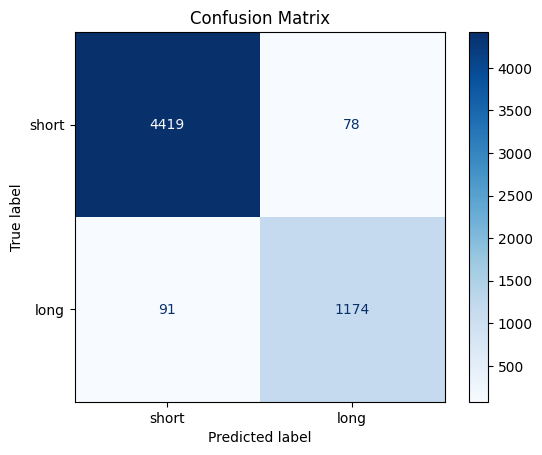

In [72]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['short', 'long'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

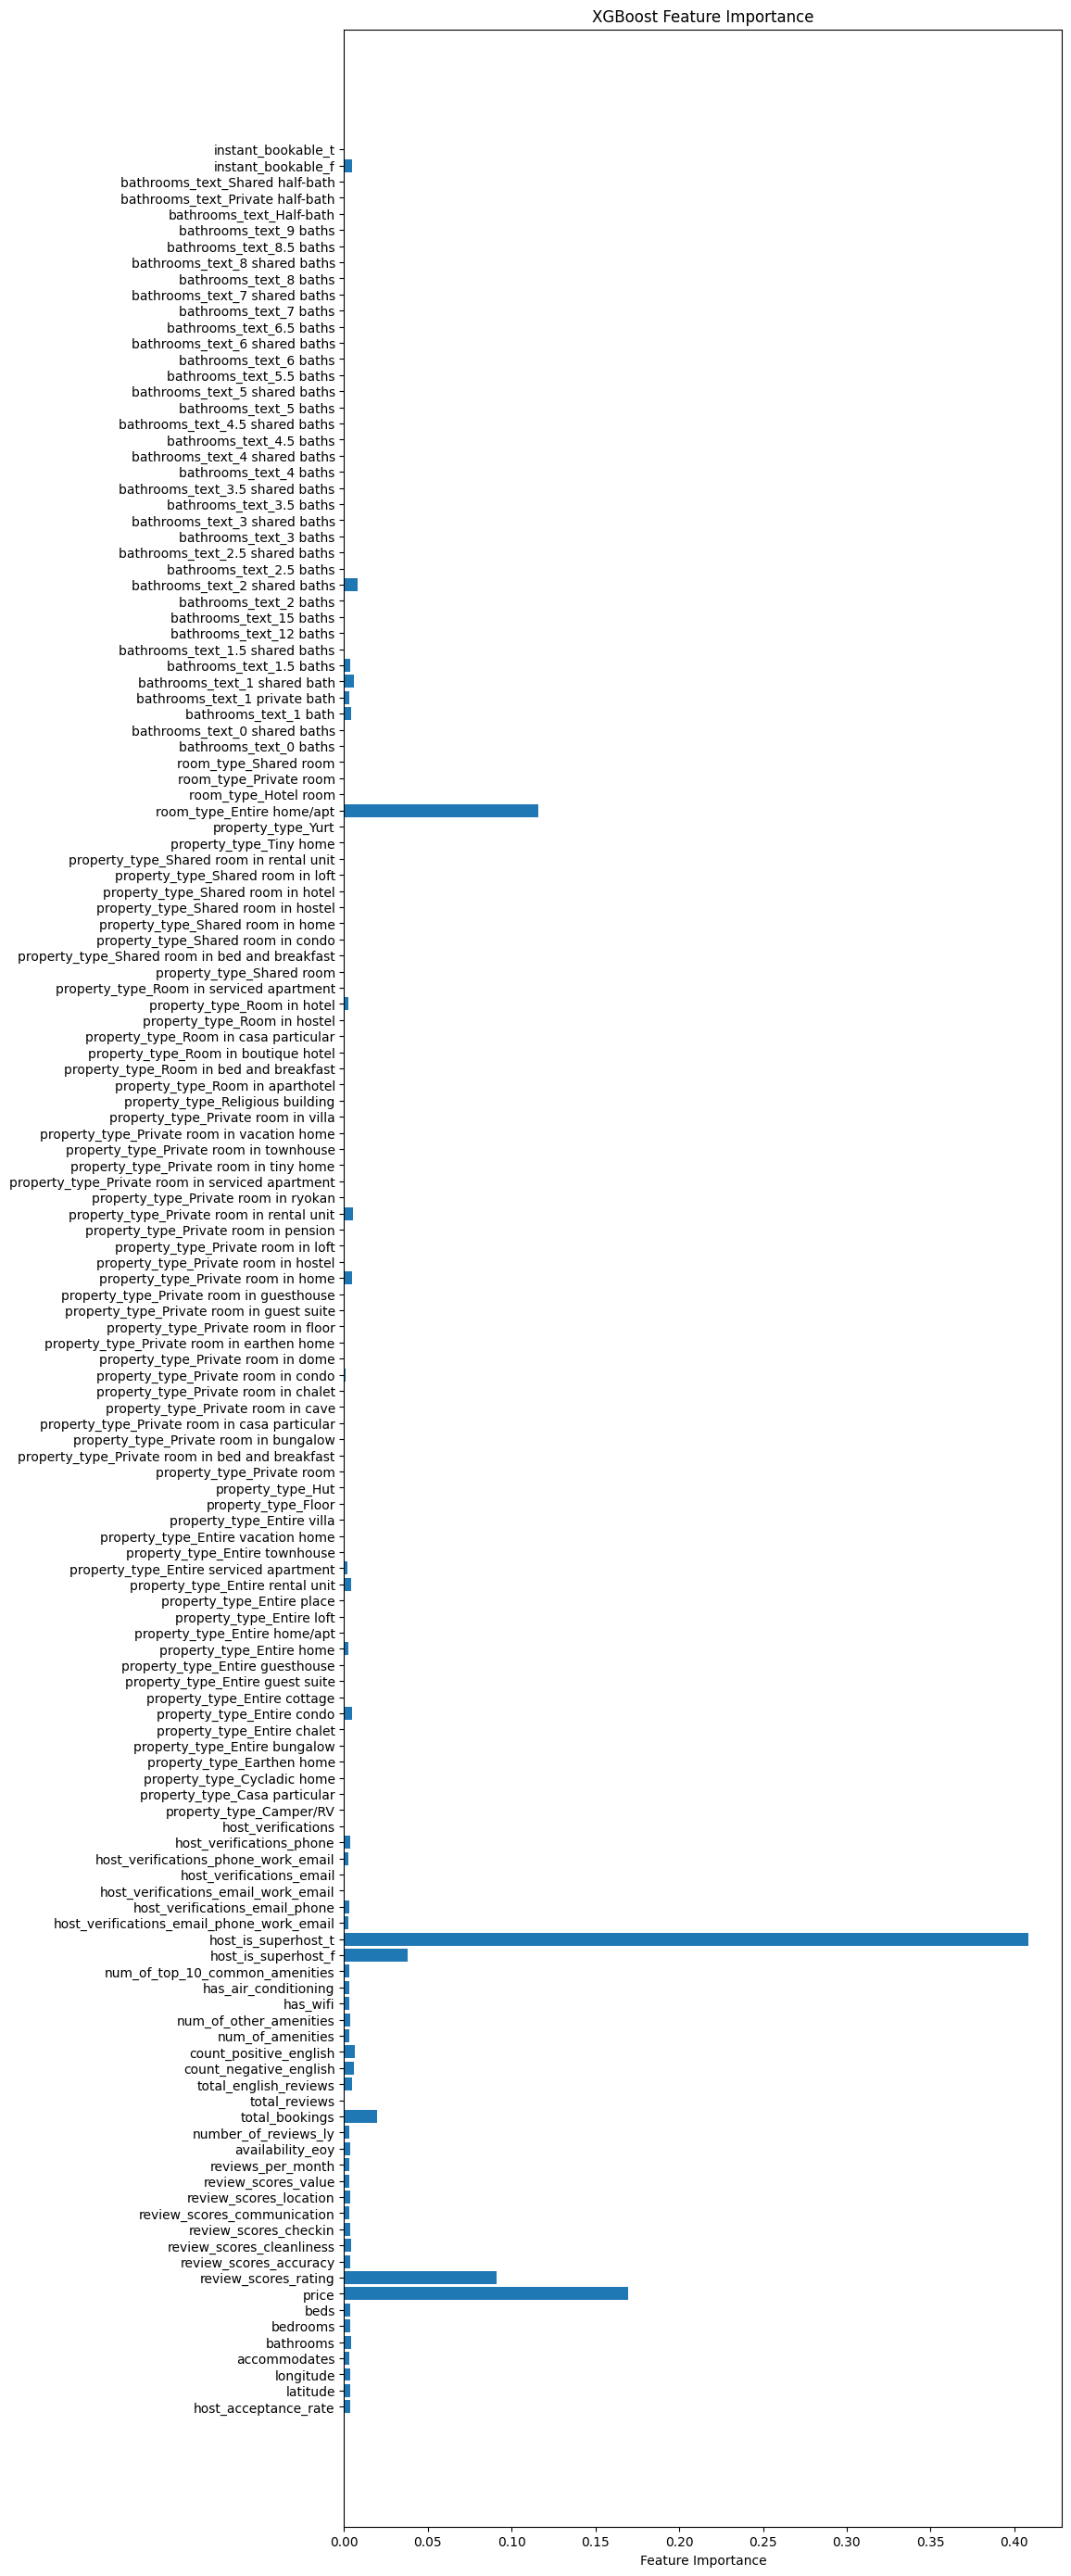

In [ ]:
importances = xgb_classifier.feature_importances_

plt.figure(figsize=(10, 35))
plt.barh(x_train.columns, importances)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

# Modele Regresyjne

### Model Naiwny - Regresja

In [ ]:
# TODO

### Model docelowy - Regresja